In [17]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio
import pandas as pd

# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

## audio, labels, speech recognition

0 i ------------------- from 0.3000 to 0.4200 sec, confidence: 100.00%
1 skymningen ---------- from 0.4200 to 1.2600 sec, confidence: 100.00%
2 en ------------------ from 1.3500 to 1.5000 sec, confidence: 100.00%
3 mycket -------------- from 1.5000 to 1.8000 sec, confidence: 100.00%
4 het ----------------- from 1.8300 to 2.1000 sec, confidence: 100.00%
5 dag ----------------- from 2.1000 to 2.4300 sec, confidence: 100.00%
6 i ------------------- from 2.4300 to 2.5200 sec, confidence: 100.00%
7 början -------------- from 2.5200 to 2.7900 sec, confidence: 100.00%
8 av ------------------ from 2.7900 to 2.9100 sec, confidence: 100.00%
9 juli ---------------- from 2.9100 to 3.3600 sec, confidence: 100.00%
10 lämnade ------------- from 3.3600 to 3.9900 sec, confidence: 100.00%
11 en ------------------ from 3.9900 to 4.1400 sec, confidence: 100.00%
12 ung ----------------- from 4.1400 to 4.4100 sec, confidence: 100.00%
13 man ----------------- from 4.4100 to 4.6800 sec, confidence: 100.00%
14

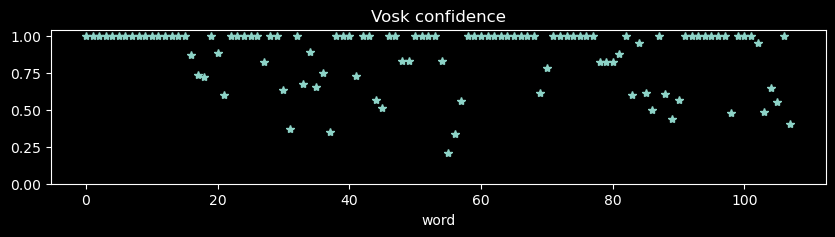

In [18]:
audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"

Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"

if "model" not in locals():
    model = Model(model_path)

words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])

# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [19]:
labels_path = (
    "example_speech_Andreas/180923214834-Y20UOTIE-text-000_vowels_timestamp_praat"
)

labels_df = pd.read_csv(labels_path)
display(labels_df)

,tmin,tmax
0,0.560813,0.610813
1,0.634599,0.684599
2,0.700651,0.750651
3,0.841320,0.891320
4,0.905731,0.955731
...,...,...
170,42.950020,43.000020
171,43.119169,43.169169
172,43.310235,43.394727
173,43.557646,43.607646


In [20]:
reload(tools)
add_context = False
fl = int(0.02 * Fs)
grouped_frames = tools.julgran(words, audio, Fs, fl, add_context, long_frame=True)

vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1


print("found vowels:")
for v in grouped_frames.keys():
    print(
        "    ",
        v,
        len(grouped_frames[v]["frame"]),
        str(round(100 * len(grouped_frames[v]["frame"]) / vowels_in_text[v], 3)) + "%",
    )

print("total: vowels in text", sum([vowels_in_text[v] for v in vowels_in_text.keys()]))
for v in vowels_in_text.keys():
    print(vowels_in_text[v])

keep i


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w


keep skymningen
trash en
trash mycket
trash het
keep dag
keep i


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )


trash början
keep av
trash juli
keep lämnade
trash en
trash ung
keep man
keep sin
trash kammare
keep vid
trash steg
keep ut
keep på
trash gatan
keep och
trash långsamt
keep och
trash obeslutsam
trash lyckligtvis
keep slapp
trash han
trash värdinnan
trash i
trash kammare
trash som
keep in
keep under
keep den
keep höga
trash minst
trash ha
keep liknande
trash snart
keep ska
keep jag
trash köpa
trash en
keep bostad
keep värdinnan
keep som
keep vind
keep skutan
trash och
trash höll
keep honom
keep med
keep middag
trash städning
keep en
trash ner
trash och
keep när
keep han
trash skulle
trash ut
keep måste
trash passera
keep värdinnan
keep kex
trash alltid
found vowels:
     e 9 24.324%
     y 1 25.0%
     u 3 30.0%
     i 11 45.833%
     o 6 33.333%
     å 2 25.0%
     a 15 31.25%
     ö 1 11.111%
     ä 4 50.0%
total: vowels in text 166
37
4
10
24
18
8
48
9
8


In [21]:
starts_all_seconds, stops_all_seconds = tools.get_start_stop_seconds(
    grouped_frames, fl, Fs
)
tools.score_vs_labels(starts_all_seconds, stops_all_seconds, labels_df, snäll=True)

total found vowels: 52
unique start points: 52
included: 31
Assuming Praat perfect and all vowels correctly classified:
precision: 0.5961538461538461
recall: 0.17714285714285713


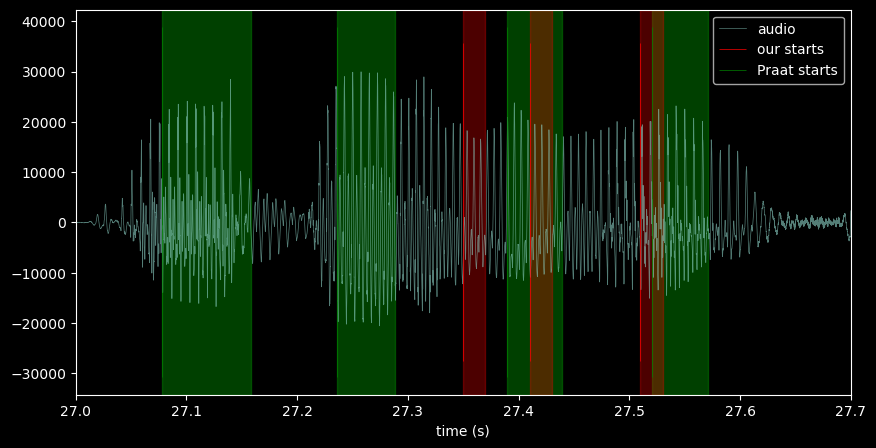

In [22]:
plt.figure(figsize=(10, 5))

tt = np.arange(len(audio)) / Fs
plt.plot(tt, audio, alpha=0.6, label="audio")
plt.vlines(starts_all_seconds, *plt.ylim(), colors="r", label="our starts")
plt.vlines(labels_df.tmin, *plt.ylim(), colors="g", label="Praat starts")
for tmin, tmax in zip(labels_df.tmin, labels_df.tmax):
    plt.axvspan(tmin, tmax, alpha=0.5, color="g")

for start, stop in zip(starts_all_seconds, stops_all_seconds):
    plt.axvspan(start, stop, alpha=0.3, color="r")


plt.xlabel("time (s)")

tr = (27.0, 27.7)

plt.xlim(*tr)
plt.legend()
plt.show()

In [23]:
wavfile.write(
    "output/test.wav", Fs, tools.wavScaler(audio[int(tr[0] * Fs) : int(tr[1] * Fs)])
)

## outlier filter

In [24]:
reload(tools)
frames_inliers = tools.outlier_filter(grouped_frames, Fs)
starts_all_seconds_in, stops_all_seconds_in = tools.get_start_stop_seconds(
    frames_inliers, fl, Fs
)

tools.score_vs_labels(starts_all_seconds_in, stops_all_seconds_in, labels_df)

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


inliers (e): 44.0 %
inliers (y): 100.0 %


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


inliers (u): 100.0 %
inliers (i): 73.0 %


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


inliers (o): 83.0 %
inliers (å): 100.0 %


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


inliers (a): 67.0 %
inliers (ö): 100.0 %


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


inliers (ä): 75.0 %
total found vowels: 37
unique start points: 37
included: 13
Assuming Praat perfect and all vowels correctly classified:
precision: 0.35135135135135137
recall: 0.07428571428571429
